
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [6]:
## library imports here
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import f1_score
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [7]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [8]:
X = ha.drop(columns = ['cp'],axis=1)
y = ha['cp']

In [9]:
# Create a column transformer standardizing and dummify all necessary variables
ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
  ],
  remainder = "passthrough"
)
# create a KNN pipeline
knn_pipeline = Pipeline(
  [("preprocess", ct),
  ("knn", KNeighborsClassifier())]
)
cross_val_score(knn_pipeline, X, y, scoring = "roc_auc_ovo", cv=5).mean()
#Changes ovo to ovr in chapter 18 talks abt the difference
#cross_val_score(knn_pipeline, X, y, scoring = "roc_auc_ovr", cv=5).mean()

0.5756261207474443

In [10]:
# create a decision tree pipeline
dt_pipeline = Pipeline(
  [("preprocess", ct),
  ("dt", DecisionTreeClassifier(max_depth=2))]
)
cross_val_score(dt_pipeline, X, y, scoring = "roc_auc_ovo", cv=5).mean()

0.607999937154349

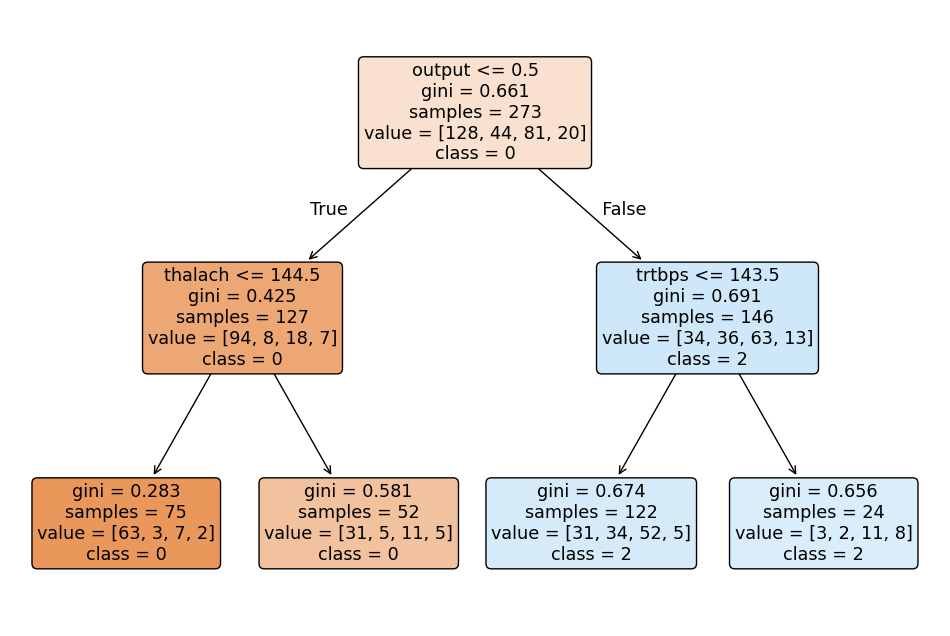

In [11]:
# For the decision tree, plot the fitted tree, and interpret the first couple splits. Usiing plot 9
# max depth in lab
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
# Fit the pipeline
dt_pipeline.fit(X, y)

tree_model = dt_pipeline.named_steps['dt']

plt.figure(figsize=(12, 8))  # Adjust figure size as needed
plot_tree(tree_model,
          feature_names=list(X.columns),  # Use feature names from X
          class_names=['0', '1', '2', '3'],  # Replace with your class names
          filled=True,
          rounded=True)
plt.show()


In [12]:
#create a lda pipeline
lda_pipeline = Pipeline(
  [("preprocess", ct),
  ("lda", LinearDiscriminantAnalysis())]
)
cross_val_score(lda_pipeline, X, y, scoring = "roc_auc_ovo", cv=5).mean()

0.6652907920646892

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [13]:
ha['cp_is_3'] = (ha['cp'] == 3).astype(int)
X = ha.drop(columns = ['cp', 'cp_is_3'])
y = ha['cp_is_3']

In [14]:
ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

lr_pipeline_1 = Pipeline(
  [("preprocess", ct),
  ("Logistic_regression", LogisticRegression())]
)

#Use roc_auc scoring beacuse the data set is not balanced
cross_val_score(lr_pipeline_1, X, y, scoring = "roc_auc", cv=5).mean()
y_pred = cross_val_predict(lr_pipeline_1, X, y, cv=5)
f1_c3 = f1_score(y, y_pred)
f1_c3

0.0

In [15]:
#make a new column to hold the data when cp = 0
ha['cp_is_0'] = (ha['cp'] == 0).astype(int)
X = ha.drop(columns = ['cp', 'cp_is_0','cp_is_3'])
y = ha['cp_is_0']

#cross_val_score(lr_pipeline_1, X, y, scoring = "roc_auc", cv=5).mean()
y_pred = cross_val_predict(lr_pipeline_1, X, y, cv=5)
f1_c0 = f1_score(y, y_pred)
f1_c0

0.7159533073929961

In [16]:
ha['cp_is_1'] = (ha['cp'] == 1).astype(int)
X = ha.drop(columns = ['cp', 'cp_is_1','cp_is_0','cp_is_3'])
y = ha['cp_is_1']
#cross_val_score(lr_pipeline_1, X, y, scoring = "roc_auc", cv=5).mean()
y_pred = cross_val_predict(lr_pipeline_1, X, y, cv=5)
f1_c1 = f1_score(y, y_pred)
f1_c1

0.0

In [17]:
ha['cp_is_2'] = (ha['cp'] == 2).astype(int)
X = ha.drop(columns = ['cp', 'cp_is_2','cp_is_1','cp_is_0','cp_is_3'])
y = ha['cp_is_2']
#cross_val_score(lr_pipeline_1, X, y, scoring = "roc_auc", cv=5).mean()
y_pred = cross_val_predict(lr_pipeline_1, X, y, cv=5)
f1_c2 = f1_score(y, y_pred)
f1_c2
# Roc_auc tells us the confidence it ha sin guessing the difference between one value vs the other
#Accuracy good only when you used a balanced data set



0.2127659574468085

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [18]:
filtered_ha = ha[ha['cp'].isin([0, 1])]
filtered_ha
X = filtered_ha.drop(columns = ['cp', 'cp_is_3', 'cp_is_2', 'cp_is_1', 'cp_is_0'])
y = filtered_ha['cp']

ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

lr_pipeline_2 = Pipeline(
  [("preprocess", ct),
  ("Logistic_regression", LogisticRegression(max_iter=1000))]
)

#ROC is the line and AUC ins the area under the line
cross_val_score(lr_pipeline_2, X, y, scoring = "roc_auc", cv=5).mean()

0.8376709401709401

In [19]:
filtered_ha = ha[ha['cp'].isin([0, 2])]
filtered_ha
X = filtered_ha.drop(columns = ['cp', 'cp_is_3', 'cp_is_2', 'cp_is_1', 'cp_is_0'])
y = filtered_ha['cp']

ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

lr_pipeline_3 = Pipeline(
  [("preprocess", ct),
  ("Logistic_regression", LogisticRegression(max_iter=1000))]
)

#ROC is the line and AUC ins the area under the line
cross_val_score(lr_pipeline_3, X, y, scoring = "roc_auc", cv=5).mean()

0.7511029411764706

In [20]:
filtered_ha = ha[ha['cp'].isin([0, 3])]
filtered_ha
X = filtered_ha.drop(columns = ['cp', 'cp_is_3', 'cp_is_2', 'cp_is_1', 'cp_is_0'])
y = filtered_ha['cp']

ct = ColumnTransformer(
  [
    ("dummify", OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform="pandas")

lr_pipeline_4 = Pipeline(
  [("preprocess", ct),
  ("Logistic_regression", LogisticRegression(max_iter=1000))]
)

#ROC is the line and AUC ins the area under the line
cross_val_score(lr_pipeline_4, X, y, scoring = "roc_auc", cv=5).mean()

0.7412307692307692

The pair that was the best OvO approach was the model comparing the 0 to 1 chest pain. This is because it has the high ROC_AUC score which signifies the model's ability to seperate the classes given.